In [50]:
import os, importlib, sys, time

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [52]:
import scipy.linalg as la
import scipy.stats as stats
import scipy.optimize as opt

In [53]:
import freqepid

In [54]:
# save_dir = "result_ebcr"
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)

# 0. parameters

In [55]:
GPi = np.load('data/GPi.npz')

In [56]:
param = pd.read_feather('data/param_ebcr_0.feather')
thetas = param.iloc[:,-3:].to_numpy()

In [57]:
regions = param.region.to_numpy()
num_region = len(regions)
d = thetas.shape[-1]-1

In [58]:
betas = thetas[:,-2:]

(array([ 1.,  0.,  6., 12., 18., 32., 19.,  8.,  2.,  2.]),
 array([-3.76190094, -3.42745122, -3.09300149, -2.75855177, -2.42410205,
        -2.08965233, -1.7552026 , -1.42075288, -1.08630316, -0.75185344,
        -0.41740371]),
 <BarContainer object of 10 artists>)

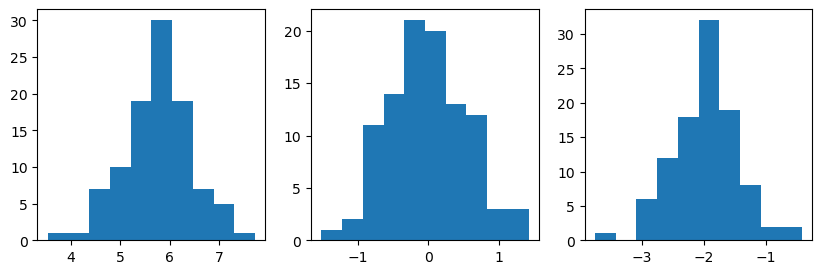

In [59]:
plt.figure(figsize=(10,3))
plt.subplot(1,3,1); plt.hist(thetas[:,0])
plt.subplot(1,3,2); plt.hist(thetas[:,1])
plt.subplot(1,3,3); plt.hist(thetas[:,2])

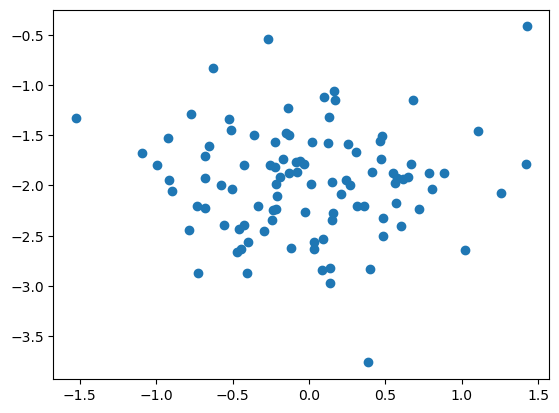

In [60]:
plt.scatter(thetas[:,1], thetas[:,2])

# 1. data

In [61]:
data = pd.read_feather('data/simulation_ebcr_0.feather')

In [62]:
data

region  date         R            EI     infection          EY  death  \
0        aa     0  2.051356    268.942888    268.942888    1.253463      2   
1        aa     1  2.051356    274.125233    274.125233    1.261948      1   
2        aa     2  2.051356    293.149608    293.149608    1.269390      1   
3        aa     3  2.051356    323.389441    323.389441    1.276013      1   
4        aa     4  2.051356    361.493441    361.493441    1.282592      1   
...     ...   ...       ...           ...           ...         ...    ...   
5926     dv    57  0.793476  12406.975638  12406.975638  258.117966    202   
5927     dv    58  0.793476  12018.384962  12018.384962  251.482833    249   
5928     dv    59  0.793476  11641.965078  11641.965078  244.854087    134   
5929     dv    60  0.793476  11277.334793  11277.334793  238.205892    233   
5930     dv    61  0.793476  10924.124851  10924.124851  231.615626    210   

      intervention  
0                0  
1                0  
2                0  
3                0  
4                0  
...            ...  
5926             1  
5927             1  
5928             1  
5929             1  
5930             1  

[5931 rows x 8 columns]

# 2. fit

In [63]:
model = freqepid.Model(GPi['g'], GPi['pi'], T0=40, family='nbinom')

In [64]:
ns_mle = np.zeros(num_region)
ms_mle = np.zeros(num_region)
bs_mle = np.zeros((num_region,d))
Vs_mle = np.zeros((num_region,d+2,d+2))

In [65]:
for i_region, r in enumerate(regions):
    start_sim = time.time()
    
    data_i = data[data['region']==r]
    T = len(data_i)
    A = np.stack([np.full(T, 1), data_i["intervention"].to_numpy()], -1)
    Y = data_i["death"].to_numpy()
    
    # fit
    nmle, mmle, bmle, ll =\
    model.fit(A, Y, n_iter=200, step_size=1,
              history=False, verbose=False)
    
    ns_mle[i_region] = nmle
    ms_mle[i_region] = mmle
    bs_mle[i_region,:] = bmle

#     nmle = ns_mle[i_region]
#     mmle = ms_mle[i_region]
#     bmle = bs_mle[i_region,:]
    
    Ihat_dth, Ihat_hac, Ihat_sdw =\
    model.inference(A, Y, nmle, mmle, bmle)
    
    Vs_mle[i_region] = la.pinv(Ihat_dth)
    
    sys.__stdout__.write("%d-th region finished, %f sec.\n"
                         %(i_region+1, time.time()-start_sim))
    sys.__stdout__.flush()

/Users/blueconet/mambaforge/envs/freqepid/lib/python3.10/site-packages/freqepid/model.py:141: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  bhaty = np.linalg.lstsq(Xy, Yy)[0]
/Users/blueconet/mambaforge/envs/freqepid/lib/python3.10/site-packages/freqepid/model.py:146: RuntimeWarning: divide by zero encountered in log
  log_err_ratio = np.log(Y / self.predict_EY(A, 0, binit))


1-th region finished, 3.071215 sec.
2-th region finished, 1.878643 sec.
3-th region finished, 0.990398 sec.
4-th region finished, 1.053817 sec.
5-th region finished, 1.155011 sec.
6-th region finished, 1.245289 sec.
7-th region finished, 1.443273 sec.
8-th region finished, 1.128844 sec.
9-th region finished, 1.240072 sec.
10-th region finished, 2.637095 sec.
11-th region finished, 1.071932 sec.


/Users/blueconet/mambaforge/envs/freqepid/lib/python3.10/site-packages/freqepid/model.py:234: RuntimeWarning: overflow encountered in square
  d2l_dEY2 = - Y/EYhat**2 + (nhat+Y)/(nhat+EYhat)**2


12-th region finished, 3.049563 sec.
13-th region finished, 1.605291 sec.
14-th region finished, 1.147723 sec.
15-th region finished, 1.175123 sec.
16-th region finished, 1.554247 sec.
17-th region finished, 1.648955 sec.
18-th region finished, 1.163258 sec.
19-th region finished, 1.226594 sec.
20-th region finished, 1.453189 sec.
21-th region finished, 1.117718 sec.
22-th region finished, 1.074046 sec.
23-th region finished, 1.973408 sec.
24-th region finished, 1.485456 sec.
25-th region finished, 2.604196 sec.
26-th region finished, 2.175218 sec.
27-th region finished, 1.271858 sec.
28-th region finished, 1.732989 sec.
29-th region finished, 12.402954 sec.
30-th region finished, 1.436600 sec.
31-th region finished, 1.520634 sec.
32-th region finished, 1.151356 sec.
33-th region finished, 1.319569 sec.
34-th region finished, 1.330188 sec.
35-th region finished, 1.462103 sec.
36-th region finished, 2.196912 sec.
37-th region finished, 1.613300 sec.
38-th region finished, 1.204575 sec.


In [66]:
# np.savez('result_freqepi_ebcr1.npz',
#          ns_mle = ns_mle, ms_mle = ms_mle, 
#          bs_mle = bs_mle, Vs_mle = Vs_mle)

## plot

In [67]:
# locals().update(np.load('simulation_freqepi_ebcr1.npz'))

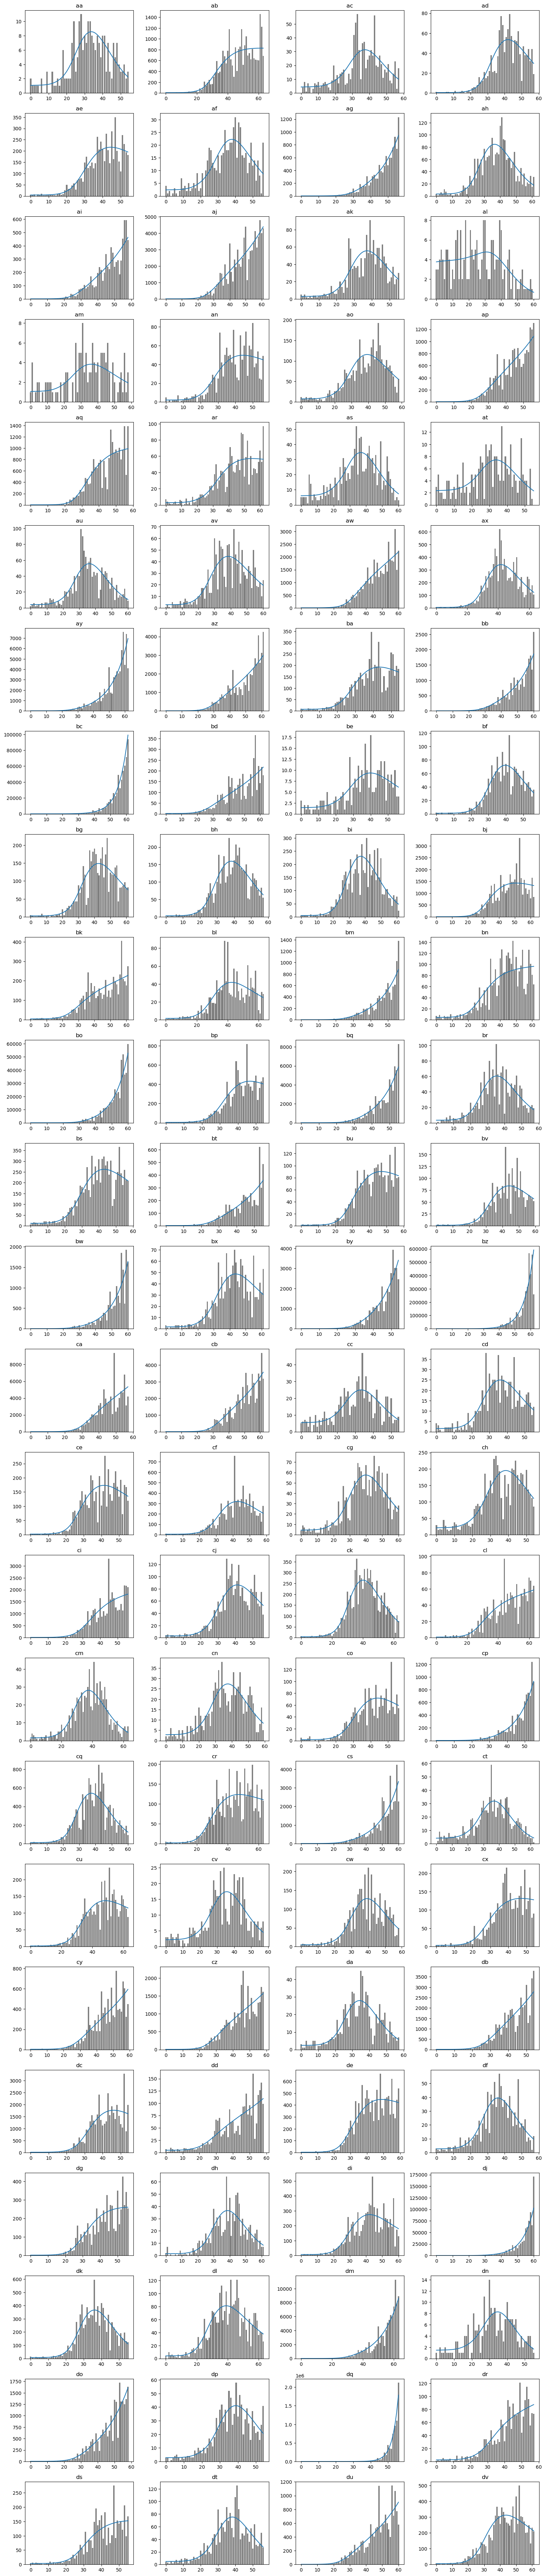

In [68]:
plt.figure(figsize=(16, int(num_region/4+1)*3))

for i, r in enumerate(regions):
    plt.subplot(int(num_region/4+1),4,i+1)
    
    Y = np.array(data[data.region == r].death)
    T = Y.shape[0]
    
    A = np.zeros([T, d])
    A[:,0] = np.full(T, 1)
    A[:,1:] = np.array(data[data.region == r].intervention)[:,None]

    plt.bar(np.arange(T), Y, color='grey')
    plt.plot(model.predict_EY(A, ms_mle[i], bs_mle[i]))
    plt.title('%s'%r)
    
plt.tight_layout()

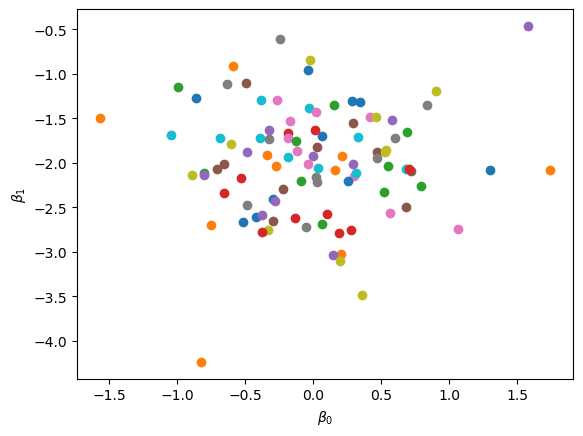

In [69]:
for i_region, (beta, bmle, Vmle) \
in enumerate(zip(betas, bs_mle, Vs_mle)):
    p = plt.scatter(*bmle, label="%d"%i_region)
#     plt.arrow(*beta, *(bmle-beta), width=0.01, 
#               length_includes_head=True,
#               color=p.get_facecolor(), alpha=1)
#     freqepid.confidence_ellipse(
#         bmle, Vmle[2:,2:], n_std=np.sqrt(stats.chi2(2).ppf(0.95)),
#         facecolor=p.get_facecolor(), alpha=0.3)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); # plt.legend()

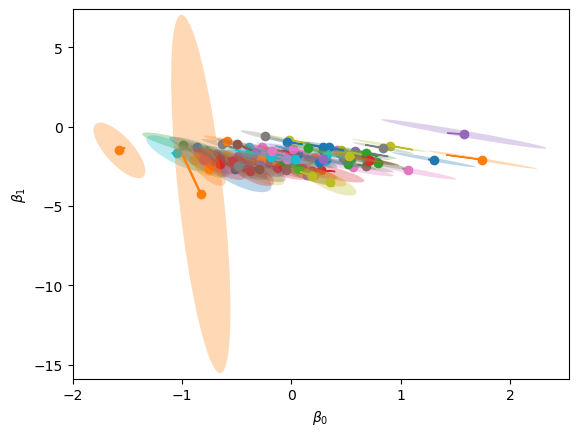

In [70]:
for i_region, (beta, bmle, Vmle) \
in enumerate(zip(betas, bs_mle, Vs_mle)):
    p = plt.scatter(*bmle, label="%d"%i_region)
    plt.arrow(*beta, *(bmle-beta), width=0.01, 
              length_includes_head=True,
              color=p.get_facecolor(), alpha=1)
    freqepid.confidence_ellipse(
        bmle, Vmle[2:,2:], n_std=np.sqrt(stats.chi2(2).ppf(0.95)),
        facecolor=p.get_facecolor(), alpha=0.3)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); # plt.legend()

In [71]:
X2_mle = ((bs_mle - betas)[:,None,:] @ np.linalg.pinv(Vs_mle[:,2:,2:]) @ (bs_mle - betas)[:,:,None])[:,0,0]

In [72]:
np.mean(X2_mle < stats.chi2(2).ppf(0.95))

0.91

# 3. EBCR

In [73]:
thats = np.concatenate([ms_mle[:,None], bs_mle], -1)
covs = Vs_mle[:,1:,1:]

In [74]:
result_ebcr = freqepid.EBCR(thats, covs, num_mc=1000, weights=np.full(100, 1))

In [75]:
ths_eb = result_ebcr.ths_eb

In [76]:
covs_eb = result_ebcr.covs_eb

In [77]:
chi_pa = result_ebcr.chi_pa(0.05)

## plots

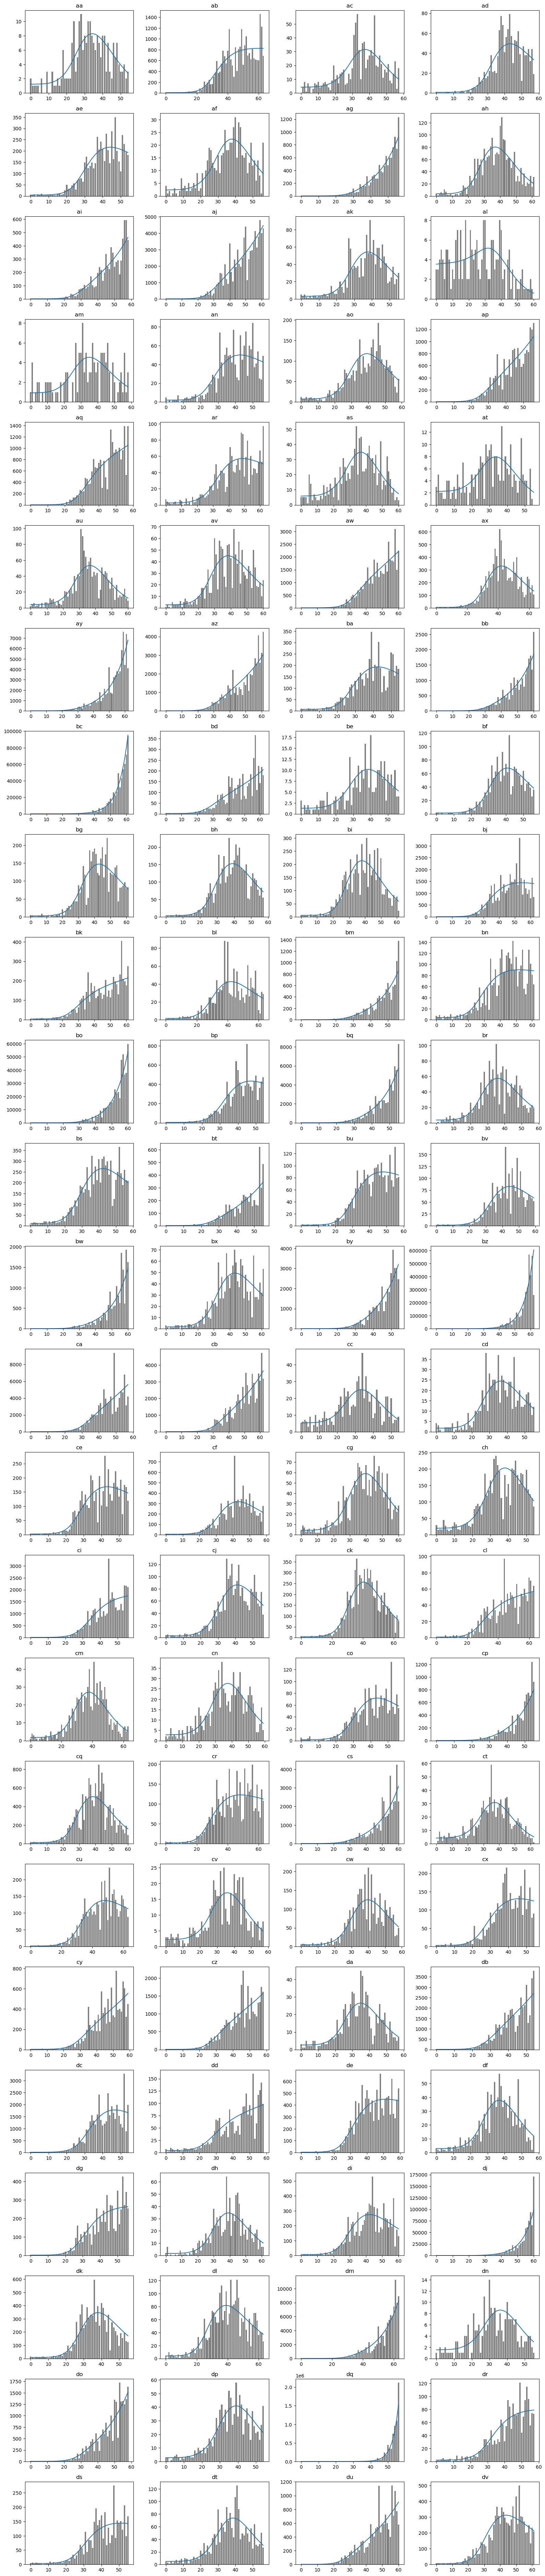

In [78]:
plt.figure(figsize=(16, int(num_region/4+1)*3))

for i, r in enumerate(regions):
    plt.subplot(int(num_region/4+1),4,i+1)
    
    Y = np.array(data[data.region == r].death)
    T = Y.shape[0]
    
    A = np.zeros([T, d])
    A[:,0] = np.full(T, 1)
    A[:,1:] = np.array(data[data.region == r].intervention)[:,None]

    plt.bar(np.arange(T), Y, color='grey')
    plt.plot(model.predict_EY(A, ths_eb[i,0], ths_eb[i,1:]))
    plt.title('%s'%r)
    
plt.tight_layout()

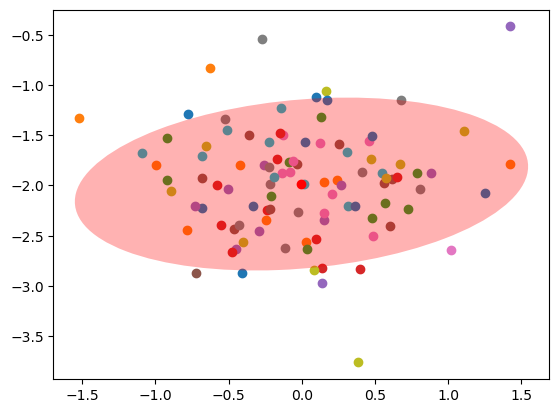

In [79]:
for i_region, beta in enumerate(betas):
    p = plt.scatter(*beta)
    
p = plt.scatter(*result_ebcr.th_o[1:], color='red')
freqepid.confidence_ellipse(
    result_ebcr.th_o[1:], result_ebcr.Phi2[1:,1:], n_std = chi_pa,
    facecolor=p.get_facecolor(), alpha=0.3)

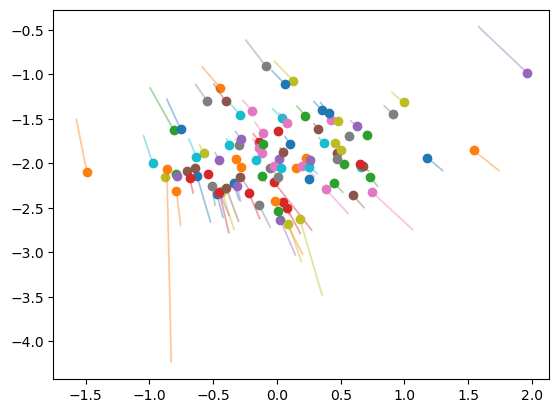

In [80]:
for i, r in enumerate(regions):
    p = plt.scatter(*ths_eb[i,1:])
    plt.arrow(*thats[i,1:], *(ths_eb[i,1:]-thats[i,1:]), width=0.005, 
             length_includes_head=True,
             color=p.get_facecolor(), alpha=0.3)

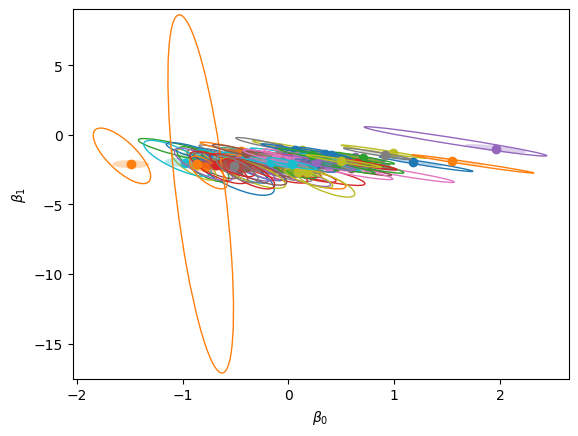

In [81]:
for i, r in enumerate(regions):
    p = plt.scatter(ths_eb[i,1], ths_eb[i,2])
    freqepid.confidence_ellipse(
        ths_eb[i,1:], covs_eb[i,1:,1:], n_std = chi_pa,
        facecolor=p.get_facecolor(), alpha=0.3)
    freqepid.confidence_ellipse(
        thats[i,1:], covs[i,1:,1:], n_std = chi_pa,
        edgecolor=p.get_facecolor(), facecolor='none', alpha=1)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); #plt.legend(loc=(1.02,0))

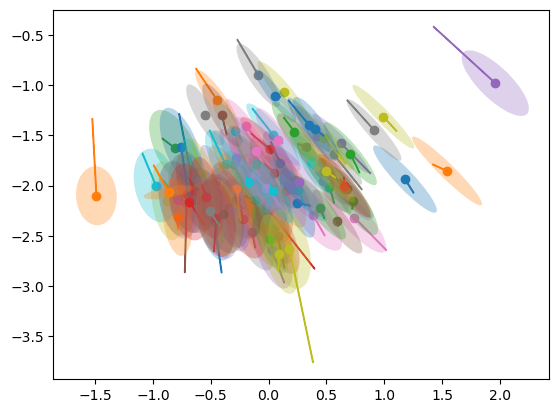

In [82]:
for i_region, (beta, th_eb, cov_eb) in enumerate(zip(betas, ths_eb, covs_eb)):
    p = plt.scatter(*(th_eb[1:]))
    plt.arrow(*beta, *(th_eb[1:]-beta), width=0.005, 
              length_includes_head=True,
              color=p.get_facecolor(), alpha=1)
    freqepid.confidence_ellipse(
        th_eb[1:], cov_eb[1:,1:], n_std = chi_pa,
        facecolor=p.get_facecolor(), alpha=0.3)

In [83]:
X2_eb = ((ths_eb[:,1:] - betas)[:,None,:] @ np.linalg.pinv(covs_eb[:,1:,1:]) @ (ths_eb[:,1:] - betas)[:,:,None])[:,0,0]

In [84]:
np.mean(X2_eb < result_ebcr.chi_pa(0.05)**2)

0.84

## robust CR

In [85]:
rho_pa = np.zeros(num_region)
rho_l = np.zeros(num_region)

In [86]:
for i, r in enumerate(regions):
    start_iter = time.time()
    
    rho_pa[i] = result_ebcr.cv.rho(chi_pa, result_ebcr.m2s[i],
                                   result_ebcr.m4s[i]+1e-2)['alpha']
    
    rho_l[i] = result_ebcr.cv.rho_l(chi_pa, result_ebcr.m2s[i],
                                    result_ebcr.m4s[i])['alpha']
    
    print("region %d finished, lapse: %.2f sec."
          %(i, time.time()-start_iter))

region 0 finished, lapse: 0.37 sec.
region 1 finished, lapse: 0.33 sec.
region 2 finished, lapse: 0.32 sec.
region 3 finished, lapse: 0.33 sec.
region 4 finished, lapse: 0.33 sec.
region 5 finished, lapse: 0.33 sec.
region 6 finished, lapse: 0.33 sec.
region 7 finished, lapse: 0.33 sec.
region 8 finished, lapse: 0.32 sec.
region 9 finished, lapse: 0.33 sec.
region 10 finished, lapse: 0.33 sec.
region 11 finished, lapse: 0.32 sec.
region 12 finished, lapse: 0.34 sec.
region 13 finished, lapse: 0.34 sec.
region 14 finished, lapse: 0.36 sec.
region 15 finished, lapse: 0.34 sec.
region 16 finished, lapse: 0.34 sec.
region 17 finished, lapse: 0.34 sec.
region 18 finished, lapse: 0.33 sec.
region 19 finished, lapse: 0.32 sec.
region 20 finished, lapse: 0.34 sec.
region 21 finished, lapse: 0.35 sec.
region 22 finished, lapse: 0.34 sec.
region 23 finished, lapse: 0.32 sec.
region 24 finished, lapse: 0.34 sec.
region 25 finished, lapse: 0.35 sec.
region 26 finished, lapse: 0.34 sec.
region 27 f

In [87]:
rho_l

array([0.39377045, 0.06976784, 0.24210187, 0.17174353, 0.08426567,
       0.19083747, 0.09331694, 0.1060211 , 0.11203249, 0.08006729,
       0.14849868, 0.51308151, 0.16470992, 0.10392499, 0.08641891,
       0.08116661, 0.12522357, 0.07498207, 0.19948107, 0.25606817,
       0.14147302, 0.09456637, 0.06963774, 0.08390041, 0.07965411,
       0.07796429, 0.08409959, 0.08846386, 0.09047111, 0.08738695,
       0.12448383, 0.15305649, 0.08761971, 0.10174431, 0.1096947 ,
       0.08122685, 0.06890227, 0.09163401, 0.10273477, 0.07615643,
       0.10092074, 0.09513529, 0.08271781, 0.14268251, 0.06875736,
       0.10199868, 0.0951305 , 0.10906684, 0.08517106, 0.0872855 ,
       0.07939132, 0.12404938, 0.08717423, 0.08459051, 0.21990735,
       0.12872063, 0.11652413, 0.09124802, 0.08598844, 0.10554986,
       0.07372883, 0.08999487, 0.07897175, 0.10784895, 0.12164489,
       0.12422525, 0.1001232 , 0.08042241, 0.11086378, 0.0908011 ,
       0.06745146, 0.21337305, 0.07419162, 0.21641028, 0.13449

In [88]:
chi_eb = np.zeros(num_region)

In [89]:
for i, r in enumerate(regions):
    start_iter = time.time()
    
    chi_eb[i] = result_ebcr.chi_eb(i, 0.05, linear=True)
    
    print("region %d finished, lapse: %.2f sec."
          %(i, time.time()-start_iter))

region 0 finished, lapse: 3.08 sec.
region 1 finished, lapse: 3.88 sec.
region 2 finished, lapse: 3.34 sec.
region 3 finished, lapse: 3.68 sec.
region 4 finished, lapse: 3.96 sec.
region 5 finished, lapse: 3.74 sec.
region 6 finished, lapse: 3.95 sec.
region 7 finished, lapse: 3.97 sec.
region 8 finished, lapse: 4.08 sec.
region 9 finished, lapse: 4.06 sec.
region 10 finished, lapse: 3.80 sec.
region 11 finished, lapse: 3.18 sec.
region 12 finished, lapse: 3.52 sec.
region 13 finished, lapse: 4.07 sec.
region 14 finished, lapse: 4.08 sec.
region 15 finished, lapse: 4.57 sec.
region 16 finished, lapse: 3.83 sec.
region 17 finished, lapse: 4.36 sec.
region 18 finished, lapse: 4.08 sec.
region 19 finished, lapse: 3.45 sec.
region 20 finished, lapse: 5.27 sec.
region 21 finished, lapse: 4.09 sec.
region 22 finished, lapse: 4.01 sec.
region 23 finished, lapse: 4.06 sec.
region 24 finished, lapse: 4.32 sec.
region 25 finished, lapse: 4.37 sec.
region 26 finished, lapse: 4.18 sec.
region 27 f

In [90]:
chi_eb

array([ 7.72136208,  2.96552709,  5.58827483,  4.3783399 ,  3.10492439,
        4.72306265,  3.20160012,  3.36547864,  3.4468508 ,  3.06138825,
        3.96738158,  9.13012581,  4.25051848,  3.33504011,  3.12635471,
        3.07308857,  3.6146394 ,  3.00973536,  4.87561593,  5.80844358,
        3.86538235,  3.21699591,  2.96445772,  3.10086726,  3.05688861,
        3.03900902,  3.10307357,  3.1480144 ,  3.16857236,  3.13687804,
        3.60376138,  4.04379616,  3.13947344,  3.30476519,  3.4218169 ,
        3.073532  ,  2.95847396,  3.18169199,  3.31833442,  3.02087643,
        3.2937225 ,  3.22416892,  3.08810868,  3.87895952,  2.95711897,
        3.3082206 ,  3.22410818,  3.41192552,  3.11380479,  3.13575422,
        3.0540525 ,  3.59746089,  3.13452677,  3.10857317,  5.22525368,
        3.66834867,  3.50143662,  3.17727363,  3.12184699,  3.35852481,
        2.99859802,  3.1633831 ,  3.04956624,  3.39304464,  3.56391704,
        3.60000332,  3.28324752,  3.06529462,  3.43418225,  3.17

In [91]:
rho_eb = np.zeros(num_region)

In [92]:
for i, r in enumerate(regions):
    start_iter = time.time()
    
#     rho_eb[i] = result_ebcr.cv.rho(chi_pa, result_ebcr.m2s[i],
#                                    result_ebcr.m4s[i]+1e-2)['alpha']
    
    rho_eb[i] = result_ebcr.cv.rho_l(chi_eb[i], result_ebcr.m2s[i],
                                    result_ebcr.m4s[i])['alpha']
    
    print("region %d finished, lapse: %.2f sec."
          %(i, time.time()-start_iter))

region 0 finished, lapse: 0.23 sec.
region 1 finished, lapse: 0.23 sec.
region 2 finished, lapse: 0.23 sec.
region 3 finished, lapse: 0.23 sec.
region 4 finished, lapse: 0.22 sec.
region 5 finished, lapse: 0.22 sec.
region 6 finished, lapse: 0.23 sec.
region 7 finished, lapse: 0.23 sec.
region 8 finished, lapse: 0.23 sec.
region 9 finished, lapse: 0.22 sec.
region 10 finished, lapse: 0.22 sec.
region 11 finished, lapse: 0.22 sec.
region 12 finished, lapse: 0.23 sec.
region 13 finished, lapse: 0.23 sec.
region 14 finished, lapse: 0.22 sec.
region 15 finished, lapse: 0.22 sec.
region 16 finished, lapse: 0.34 sec.
region 17 finished, lapse: 0.23 sec.
region 18 finished, lapse: 0.26 sec.
region 19 finished, lapse: 0.24 sec.
region 20 finished, lapse: 0.23 sec.
region 21 finished, lapse: 0.23 sec.
region 22 finished, lapse: 0.23 sec.
region 23 finished, lapse: 0.22 sec.
region 24 finished, lapse: 0.23 sec.
region 25 finished, lapse: 0.23 sec.
region 26 finished, lapse: 0.22 sec.
region 27 f

In [93]:
rho_eb

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05])

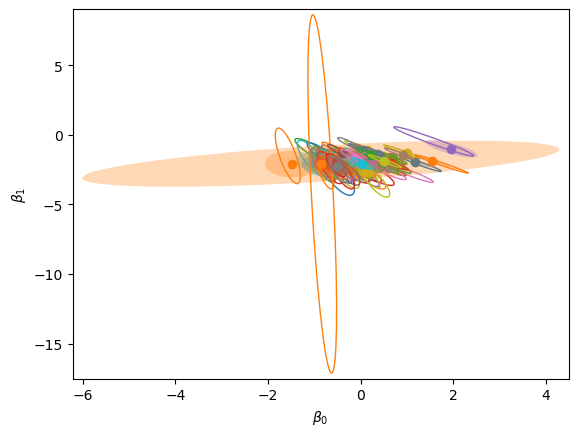

In [94]:
for i, r in enumerate(regions):
    p = plt.scatter(ths_eb[i,1], ths_eb[i,2])
    freqepid.confidence_ellipse(
        ths_eb[i,1:], covs_eb[i,1:,1:], n_std = chi_eb[i],
        facecolor=p.get_facecolor(), alpha=0.3)
    freqepid.confidence_ellipse(
        thats[i,1:], covs[i,1:,1:], n_std = chi_pa,
        edgecolor=p.get_facecolor(), facecolor='none', alpha=1)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); #plt.legend(loc=(1.02,0))

(-4.0, 0.0)

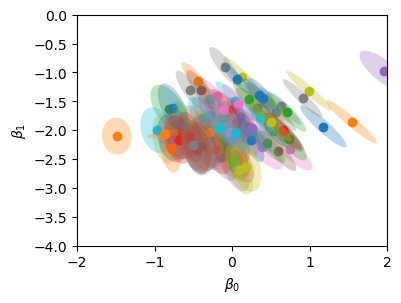

In [99]:
plt.figure(figsize=(4,3))
for i_region, (beta, th_eb, cov_eb) in enumerate(zip(betas, ths_eb, covs_eb)):
    p = plt.scatter(*(th_eb[1:]))
#     plt.arrow(*beta, *(th_eb[1:]-beta), width=0.005, 
#               length_includes_head=True,
#               color=p.get_facecolor(), alpha=1)
    freqepid.confidence_ellipse(
        th_eb[1:], cov_eb[1:,1:], n_std = chi_eb[i],
        facecolor=p.get_facecolor(), alpha=0.3)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$")
plt.xlim([-2, 2]); plt.ylim([-4, 0])

In [96]:
X2_eb = ((ths_eb[:,1:] - betas)[:,None,:] @ np.linalg.pinv(covs_eb[:,1:,1:]) @ (ths_eb[:,1:] - betas)[:,:,None])[:,0,0]

In [97]:
np.mean(X2_eb < chi_eb**2)

0.92

# 4. Causal Forecasting

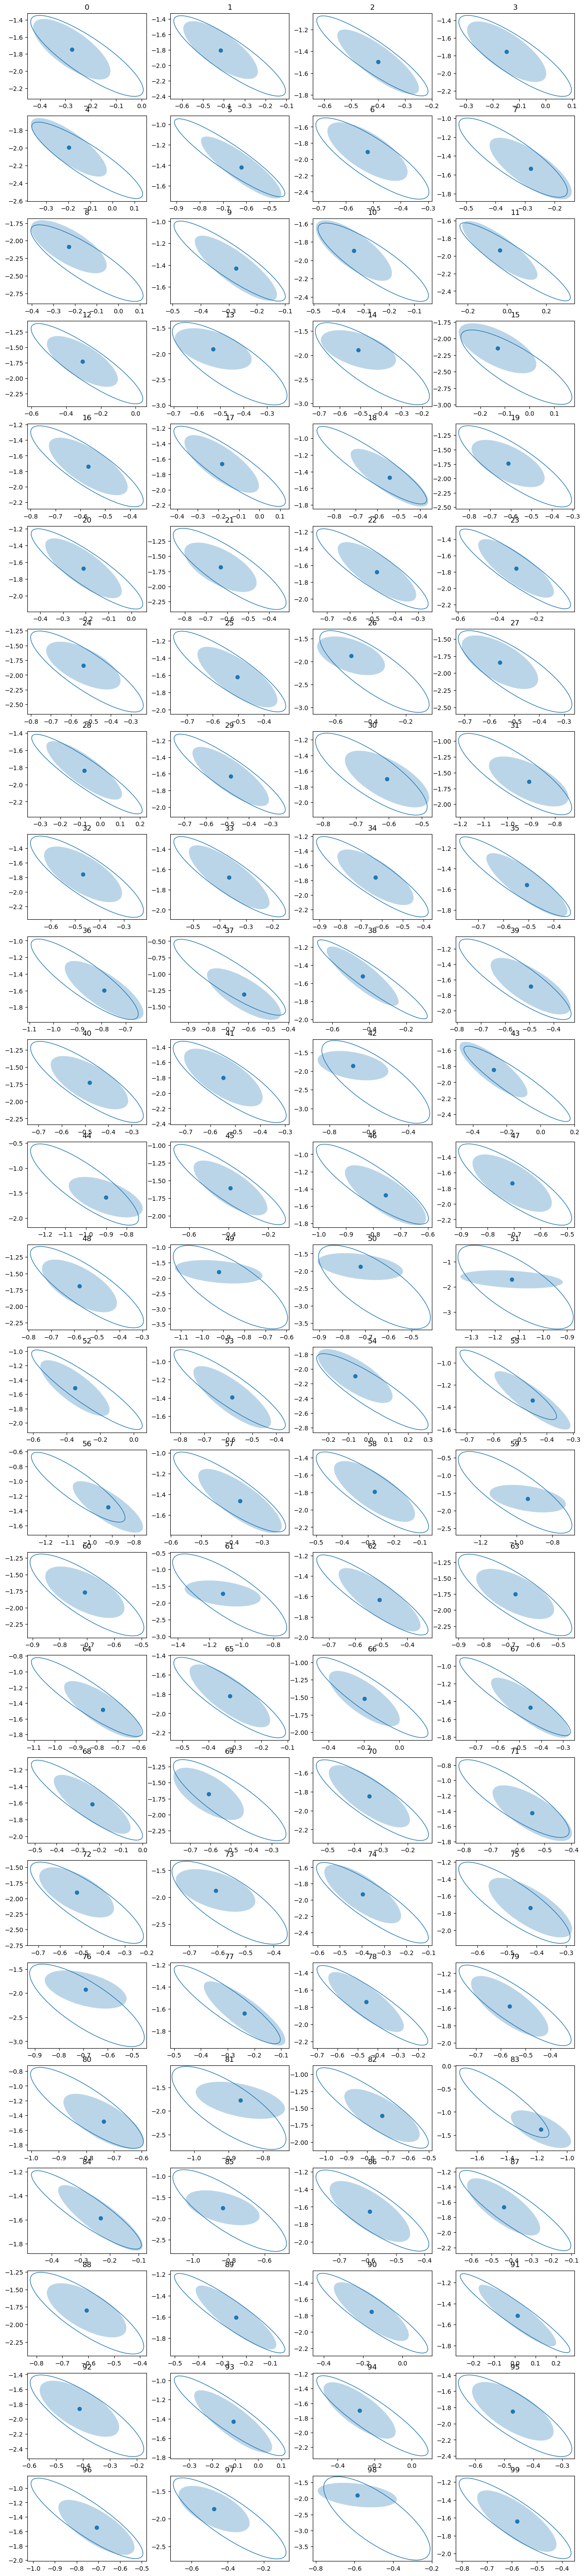

In [269]:
plt.figure(figsize=(16,int(num_region/4+1)*3))
for i, r in enumerate(regions):
    plt.subplot(int(num_region/4+1),4,i+1)
    
    p = plt.scatter(ths_eb[i,1], ths_eb[i,2])
    freqepid.confidence_ellipse(
        ths_eb[i,1:], covs_eb[i,1:,1:], n_std = chi_eb[i],
        facecolor=p.get_facecolor(), alpha=0.3)
    freqepid.confidence_ellipse(
        thats[i,1:], covs[i,1:,1:], n_std = chi_pa,
        edgecolor=p.get_facecolor(), facecolor='none', alpha=1)
    
    plt.title('%d'%i)

In [272]:
i = 22

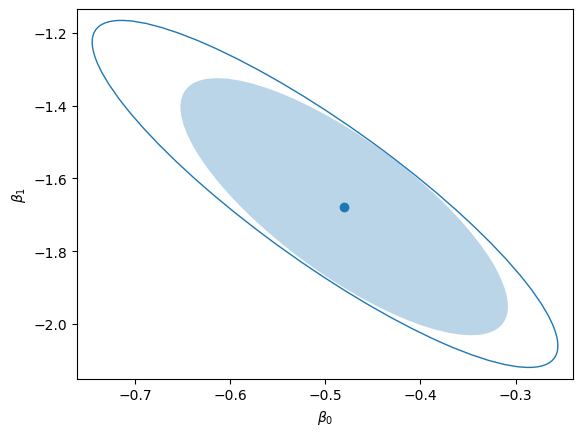

In [273]:
p = plt.scatter(ths_eb[i,1], ths_eb[i,2])
freqepid.confidence_ellipse(
    ths_eb[i,1:], covs_eb[i,1:,1:], n_std = chi_eb[i],
    facecolor=p.get_facecolor(), alpha=0.3)
freqepid.confidence_ellipse(
    thats[i,1:], covs[i,1:,1:], n_std = chi_pa,
    edgecolor=p.get_facecolor(), facecolor='none', alpha=1)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); #plt.legend(loc=(1.02,0))

In [274]:
data_i = data[data['region']==i]
T = len(data_i)
A = np.stack([np.full(T, 1), data_i["intervention"].to_numpy()], -1)
Y = data_i["death"].to_numpy()

In [275]:
Tf = 30
Af = np.zeros([Tf, d])

In [276]:
Af[:,0] = np.full(Tf, 1)
Af[:,1] = np.full(Tf, 0.5)

In [277]:
Ae = np.concatenate([A, Af], 0)

## vanilla CR

In [278]:
conf_pa, _, _ = \
model.confidence_EY(Ae, thats[i,0], thats[i,1:],
                    covs[i], chi_pa, verbose=True)

/Users/blueconet/mambaforge/envs/freqepid/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


optimization at t = 1 finished, lapse: 1.630sec.
optimization at t = 2 finished, lapse: 1.503sec.
optimization at t = 3 finished, lapse: 1.350sec.
optimization at t = 4 finished, lapse: 1.720sec.
optimization at t = 5 finished, lapse: 1.708sec.
optimization at t = 6 finished, lapse: 0.894sec.
optimization at t = 7 finished, lapse: 0.334sec.
optimization at t = 8 finished, lapse: 0.353sec.
optimization at t = 9 finished, lapse: 0.217sec.
optimization at t = 10 finished, lapse: 0.497sec.
optimization at t = 11 finished, lapse: 0.386sec.
optimization at t = 12 finished, lapse: 0.295sec.
optimization at t = 13 finished, lapse: 0.227sec.
optimization at t = 14 finished, lapse: 0.325sec.
optimization at t = 15 finished, lapse: 0.163sec.
optimization at t = 16 finished, lapse: 0.165sec.
optimization at t = 17 finished, lapse: 0.153sec.
optimization at t = 18 finished, lapse: 0.134sec.
optimization at t = 19 finished, lapse: 0.125sec.
optimization at t = 20 finished, lapse: 0.110sec.
optimizat

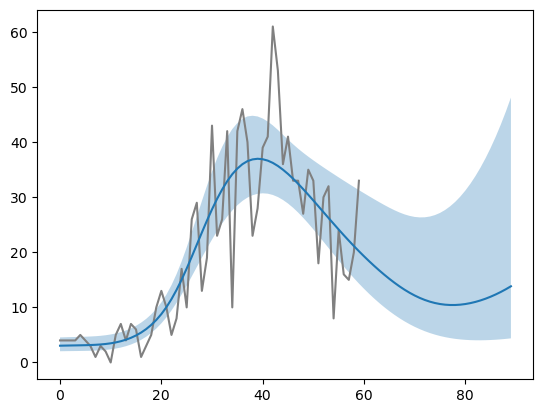

In [279]:
plt.plot(Y, color='grey')
plt.plot(model.predict_EY(Ae, thats[i,0], thats[i,1:]))
plt.fill_between(np.arange(T+Tf),
                 conf_pa[:,0], conf_pa[:,1], alpha=0.3)

## EBCR

In [280]:
conf_eb, _, _ = \
model.confidence_EY(Ae, ths_eb[i,0], ths_eb[i,1:],
                    covs_eb[i], chi_eb[i], verbose=True)

optimization at t = 1 finished, lapse: 0.797sec.
optimization at t = 2 finished, lapse: 0.408sec.
optimization at t = 3 finished, lapse: 0.902sec.
optimization at t = 4 finished, lapse: 0.446sec.
optimization at t = 5 finished, lapse: 0.758sec.
optimization at t = 6 finished, lapse: 0.253sec.
optimization at t = 7 finished, lapse: 0.158sec.
optimization at t = 8 finished, lapse: 0.203sec.
optimization at t = 9 finished, lapse: 0.260sec.
optimization at t = 10 finished, lapse: 0.198sec.
optimization at t = 11 finished, lapse: 0.187sec.
optimization at t = 12 finished, lapse: 0.106sec.
optimization at t = 13 finished, lapse: 0.168sec.
optimization at t = 14 finished, lapse: 0.149sec.
optimization at t = 15 finished, lapse: 0.173sec.
optimization at t = 16 finished, lapse: 0.210sec.
optimization at t = 17 finished, lapse: 0.129sec.
optimization at t = 18 finished, lapse: 0.097sec.
optimization at t = 19 finished, lapse: 0.088sec.
optimization at t = 20 finished, lapse: 0.132sec.
optimizat

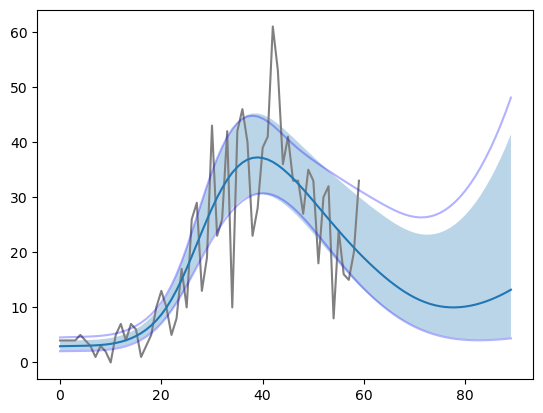

In [281]:
plt.plot(Y, color='grey')
plt.plot(model.predict_EY(Ae, ths_eb[i,0], ths_eb[i,1:]))
plt.fill_between(np.arange(T+Tf),
                 conf_eb[:,0], conf_eb[:,1], alpha=0.3)
plt.plot(conf_pa[:,0], color='blue', alpha=0.3)
plt.plot(conf_pa[:,1], color='blue', alpha=0.3)